## Setup File

Import function

In [2]:
import os
import shutil
import zipfile
import pickle
import re
import csv
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, freqz

import matplotlib.pyplot as plt
%matplotlib inline

Create Folders if not existing

In [ ]:
#File names for the angel and power data
a_data = 'Collected Data/' + 'axis_data_100_percent.txt' #The angle data 
p_data = 'Collected Data/' + '12_11_100_percent_dat.csv' #The power data

#Path to the different folders
data_path = 'data'
temp_path = data_path + '/temp'
backup_path = data_path + '/backup'

if not os.path.isdir(data_path):
    os.mkdir(data_path)
    os.mkdir(temp_path)
    os.mkdir(backup_path)

## Preprocessing

Preprocess Robotic arms trejectory

In [ ]:
with open(a_data, 'r') as file:
    try:
        data = file.read()
        file.close()
    except UnicodeDecodeError:
        file.close()
data = data.splitlines()
data = data[4:len(data)-6] #Text information on first four rows and weird data last six rows

time_steps = len(data)
data_dim = len(data[0].split()[1:])

traj_data = np.ndarray((time_steps,data_dim))
print(np.shape(traj_data))
i = 0
for row in data:
    traj_data[i] = np.array([float(n) for n in row.split()[1:]])
    i += 1


Preprocess Voltage/current Measurements

In [ ]:
f = open(p_data)

data = []
for line in f:
    data_line = line.rstrip().split('\t')
    data.append(data_line)

Volt_Amp_data = []
for file in data[9:]:
    file = file[0].replace(',','.')
    file = file.replace(' ','')
    Volt_Amp_data = Volt_Amp_data + [[float(n) for n in file.split(';')[:len(file.split(';'))]]]

Preprocessing "Calculate Power form Voltage/current measurements

In [ ]:
power_data = []
power_time = []
amp_data = []
voltage_data = []
#TODO: If statement that handles if we measure 1 or 3 phase
for sample in Volt_Amp_data:
    power = np.abs(3*sample[1]*sample[2]) \
#          + np.abs(sample[2]*sample[5]) \
#          + np.abs(sample[3]*sample[6])
    power_data.append(power)
    amp_data.append(sample[2])
    voltage_data.append(sample[1])
    power_time.append(sample[0])

Figure ploting (testing)

In [ ]:
plt.figure(figsize=(12,6))
fig = plt.subplot()
x = range(len(power_data))
fig.plot(power_time, power_data,  label='power',  marker='o',linewidth=0.3, markersize=1.5)
fig.legend();
fig.set_ylabel('Power [W]')
fig.set_xlabel('Time [s]')
fig.set_title('Total Power');

### Downsample and find start of power measurements

In [ ]:
power_data_downsampled = power_data[0:len(power_data):3]
amp_data_downsampled = amp_data[0:len(amp_data):3]
power_time_downsampled = sg.decimate(power_time, 3)
voltage_data_downsampled = sg.decimate(voltage_data, 3)

In [ ]:
Start_current_indicator = 3.8
start_point = 0
for i in range(len(amp_data)):
    if np.abs(amp_data_downsampled[i])>Start_current_indicator:
        start_point = i
        break
print('Start at sample:',start_point-1,' corresponding to time:',power_time_downsampled[start_point-1],'sec')


plt.figure(figsize=(12,6))
fig = plt.subplot()
x = range(len(power_data))
fig.plot(power_time_downsampled[0:400], np.abs(amp_data_downsampled[0:400]),  label='Current',  marker='o',linewidth=0.3, markersize=1.5)
fig.plot(power_time_downsampled[start_point-1], np.abs(amp_data_downsampled[start_point-1]),  label='Start',  marker='o',linewidth=0.3, markersize=4)
fig.legend();
fig.set_ylabel('Ampere [W]')
fig.set_xlabel('Time')
fig.set_title('Current');

In [ ]:
#Cut off power measurements at end of angle data measurements
power_data_synced = power_data_downsampled[start_point-1:start_point-1+len(traj_data)]
power_data_temp = np.ndarray((np.shape(power_data_synced)[0],1))
power_data_synced = np.array(power_data_temp)

In [ ]:
fig1, ax1 = plt.subplots()
ax1.plot(power_time_downsampled[0:400], power_data_synced[0:400],  label='Power',  marker='o',linewidth=0.3, markersize=1.5)
ax1.legend();
ax1.set_ylabel('Power [W]')
ax1.set_xlabel('Time')
ax1.set_title('Power');

fig2, ax2 = plt.subplots()
ax2.plot(power_time_downsampled[0:400], traj_data[0:400],  label='Angles',  marker='o',linewidth=0.3, markersize=1.5)
ax2.legend();
ax2.set_ylabel('Angles [deg]')
ax2.set_xlabel('Time')
ax2.set_title('Angles');

Save the data

In [ ]:
with open(data_path + '/joint_angle_data.pickle', 'wb') as file:
    pickle.dump(traj_data, file)
    file.close()
with open(data_path + '/power_data.pickle', 'wb') as file:
    pickle.dump(power_data_synced, file)
    file.close()

## Augment inputs with velocity, acceleration and pseudopower

In [3]:
data_path = 'data'
temp_path = data_path + '/temp'
backup_path = data_path + '/backup'

with open(data_path + '/joint_angle_data.pickle', 'rb') as file:
    joint_angle_data = pickle.load(file)
    file.close()
    
with open(data_path + '/power_data.pickle', 'rb') as file:
    power_data = pickle.load(file)
    file.close()

In [4]:
#Time vector for angle measurements (fixed in KUKA system)
delta_t = 0.012
t = np.ndarray((len(joint_angle_data),1))
t[0] = 0
for i in range(1,len(joint_angle_data)):
    t[i] = t[i-1] + delta_t

In [5]:
#Velocity 
vel = np.ndarray(np.shape(joint_angle_data))
for i in range(len(joint_angle_data)-1):
    vel[i] = np.divide( joint_angle_data[i+1] - joint_angle_data[i], delta_t)
vel[-1] = vel[-2]

#Acceleration
acc = np.ndarray(np.shape(joint_angle_data))
for i in range(len(joint_angle_data)-1):
    acc[i] = np.divide( vel[i+1] - vel[i], delta_t)
acc[-1] = acc[-2]

#Pseudopower
psi = np.ndarray((np.shape(joint_angle_data)[0],1))
for i in range(len(joint_angle_data)):
    psi[i] = np.sum(np.abs(vel[i]*acc[i]))

In [23]:
#Create the augmented input vector containing [angle1,..,angle6, vel1,..,vel6, acc1,..,acc6, psi] for all timesteps.
#TOOO: Should we split psi to psi1,..,psi6 ?
n_timesteps = len(t)
feature_dim = len(joint_angle_data[0])*3 + 1
aug_input = np.ndarray((n_timesteps,feature_dim))

for i in range(n_timesteps):
    aug_input[i] = np.concatenate((joint_angle_data[i], vel[i], acc[i], psi[i]), axis=None)

with open(data_path + '/augmented_input.pickle', 'wb') as file:
    pickle.dump(aug_input, file)
    file.close()

### Normalize input data

In [25]:
feature_dim = len(joint_angle_data[0])*3 + 1

aug_input_norm = np.ndarray((n_timesteps,feature_dim))
joint_angle_data_norm = np.ndarray(np.shape(joint_angle_data))
vel_norm = np.ndarray(np.shape(vel))
acc_norm = np.ndarray(np.shape(vel))
psi_norm = np.ndarray(np.shape(psi))

for i in range(n_timesteps):
    if np.max(joint_angle_data[i])<1e-2:
        joint_angle_data_norm[i] = 0
    else:
        joint_angle_data_norm[i] = joint_angle_data[i]/np.max(joint_angle_data[i])
    
    if np.max(vel[i])<1e-2:
        vel_norm[i] = 0
    else:
        vel_norm[i] = vel[i]/np.max(vel[i])
    
    if np.max(acc[i])<1e-2:
        acc_norm[i] = 0
    else:
        acc_norm[i] =acc[i]/np.max(acc[i])
        
    if np.max(psi)<1e-2:
        psi_norm[i] = 0
    else:
        psi_norm[i] = psi[i]/np.max(psi)
        
        
    aug_input_norm[i] = np.concatenate((joint_angle_data_norm[i], vel_norm[i], acc_norm[i], psi_norm[i]), axis=None)

with open(data_path + '/augmented_normalized_input.pickle', 'wb') as file:
    pickle.dump(aug_input_norm, file)
    file.close()

## Low pass filtering of power data

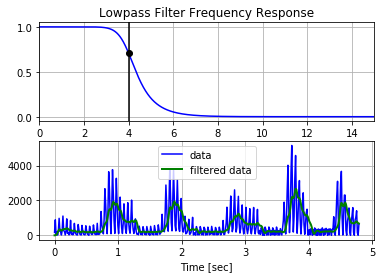

In [11]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 4  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Filter the data, and plot both the original and filtered signals.
power_filt = butter_lowpass_filter(power_data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t[0:400], power_data[0:400], 'b-', label='data')
plt.plot(t[0:400], power_filt[0:400], 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

with open(data_path + '/filtered_power_data.pickle', 'wb') as file:
    pickle.dump(power_filt, file)
    file.close()

# Plots

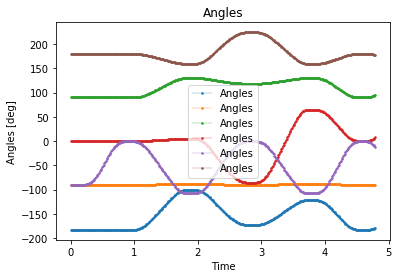

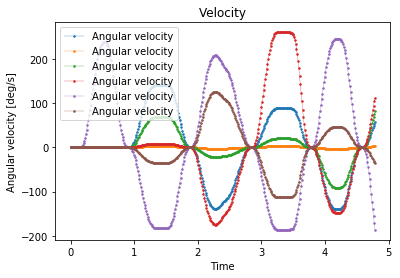

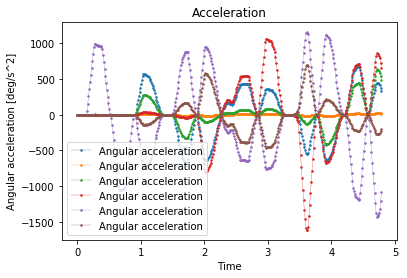

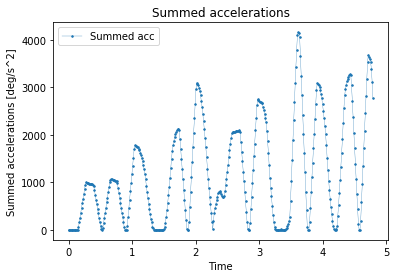

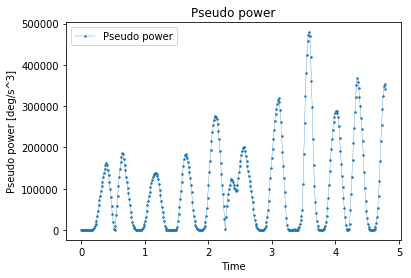

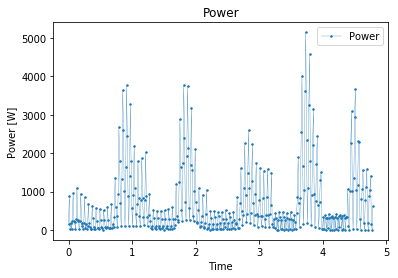

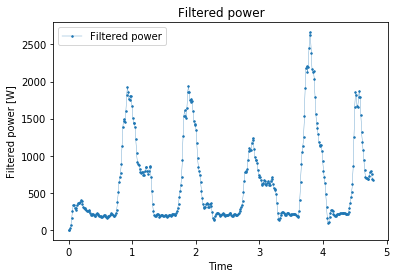

In [14]:
fig1, ax1 = plt.subplots()
ax1.plot(t[0:400], joint_angle_data[0:400],  label='Angles',  marker='o',linewidth=0.3, markersize=1.5)
ax1.legend();
ax1.set_ylabel('Angles [deg]')
ax1.set_xlabel('Time')
ax1.set_title('Angles');

fig2, ax2 = plt.subplots()
ax2.plot(t[0:400], vel[0:400],  label='Angular velocity',  marker='o',linewidth=0.3, markersize=1.5)
ax2.legend();
ax2.set_ylabel('Angular velocity [deg/s]')
ax2.set_xlabel('Time')
ax2.set_title('Velocity');

fig3, ax3 = plt.subplots()
ax3.plot(t[0:400], acc[0:400],  label='Angular acceleration',  marker='o',linewidth=0.3, markersize=1.5)
ax3.legend();
ax3.set_ylabel('Angular acceleration [deg/s^2]')
ax3.set_xlabel('Time')
ax3.set_title('Acceleration');

fig4, ax4 = plt.subplots()
ax4.plot(t[0:400], np.sum(np.abs(acc[0:400]), axis=1),  label='Summed acc',  marker='o',linewidth=0.3, markersize=1.5)
ax4.legend();
ax4.set_ylabel('Summed accelerations [deg/s^2]')
ax4.set_xlabel('Time')
ax4.set_title('Summed accelerations');

fig5, ax5 = plt.subplots()
ax5.plot(t[0:400], psi[0:400],  label='Pseudo power',  marker='o',linewidth=0.3, markersize=1.5)
ax5.legend();
ax5.set_ylabel('Pseudo power [deg/s^3]')
ax5.set_xlabel('Time')
ax5.set_title('Pseudo power');

fig6, ax6 = plt.subplots()
ax6.plot(t[0:400], power_data[0:400],  label='Power',  marker='o',linewidth=0.3, markersize=1.5)
ax6.legend();
ax6.set_ylabel('Power [W]')
ax6.set_xlabel('Time')
ax6.set_title('Power');

fig7, ax7 = plt.subplots()
ax7.plot(t[0:400], power_filt[0:400],  label='Filtered power',  marker='o',linewidth=0.3, markersize=1.5)
ax7.legend();
ax7.set_ylabel('Filtered power [W]')
ax7.set_xlabel('Time')
ax7.set_title('Filtered power');